In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

In [2]:
df = pd.read_csv("creditcard/creditcard.csv", delimiter=",")

In [3]:
print(df.shape)

(284807, 31)


In [4]:
fraud = df[df['Class'] == 1]
valid = df[df['Class'] == 0]
outlierFraction = len(fraud)/ float(len(valid))
print(f"OutlierFraction: {outlierFraction}")
print('Fraud Cases: {}'.format(len(df[df['Class'] == 1])))
print('Valid Transactions: {}'.format(len(df[df['Class'] == 0])))


OutlierFraction: 0.0017304750013189597
Fraud Cases: 492
Valid Transactions: 284315


In [5]:
print("Amount detail of the fraudulent transactions")
fraud.Amount.describe()

Amount detail of the fraudulent transactions


count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [6]:
print("Amount detail of the valid transactions")
valid.Amount.describe()

Amount detail of the valid transactions


count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

## Spliting the raw data into Input and output

### Time & amount are not that important features so we drop it from the input data and split the data into input(X) and output(y)
    - Where Input data (X) contain all the features except time and amount.
    - And Output data (y) contain only Class.

In [7]:
X = df.drop(columns=['Time', 'Amount', 'Class']).values
y = df['Class'].values
f"Shapes of X={X.shape} y={y.shape}, #Fraud Cases={y.sum()}"

'Shapes of X=(284807, 28) y=(284807,), #Fraud Cases=492'

In [8]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, make_scorer, accuracy_score

In [9]:
# split data into train and test sets
seed = 1214
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size, random_state=seed )

In [10]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(227845, 28)
(227845,)
(56962, 28)
(56962,)


In [11]:
first_model = XGBClassifier()
first_model.fit(X_train, y_train)
print(first_model)

D:\anaconda3\envs\ml\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:15:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [12]:
pred = first_model.predict(X_test)

In [13]:
accuracy = accuracy_score(y_test, pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 99.95%


## Features importancs 

[0.01776108 0.02270882 0.0148553  0.03190698 0.01922323 0.01639209
 0.02933025 0.01667766 0.01826083 0.05748048 0.01717535 0.02617349
 0.01451928 0.0619131  0.014626   0.01181433 0.4227505  0.01493303
 0.01239002 0.01450671 0.01842239 0.01727523 0.01470053 0.01285029
 0.01727785 0.02227357 0.02369064 0.01811087]


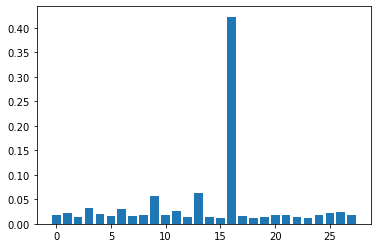

In [14]:
print(first_model.feature_importances_)

# plot
plt.bar(range(len(first_model.feature_importances_)),
first_model.feature_importances_)
plt.show()

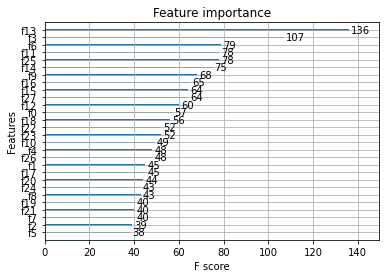

In [15]:
# using XGBOOST feature Importance Plot
from xgboost import plot_importance
plot_importance(first_model)
plt.show()

In [ ]:

from sklearn.feature_selection import SelectFromModel
thresholds = np.sort(first_model.feature_importances_)

for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(first_model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier(use_label_encoder=False)
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    prediction = selection_model.predict(select_X_test)

    acc_new = accuracy_score(y_test, prediction)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

## Evaluate Model with learing curve

In [17]:
eval_set = [(X_train, y_train), (X_test, y_test)]
second_model = XGBClassifier()
second_model.fit(
    X_train, 
    y_train, 
    eval_metric=["error", "logloss"],
    eval_set=eval_set,
    verbose=True
    )
# prediction
predictions = second_model.predict(X_test)
# evaluate pred
accuracy_2nd = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy_2nd * 100:.2f}%")

# retrieve performance metrics
results = second_model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

D:\anaconda3\envs\ml\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-error:0.00038	validation_0-logloss:0.43781	validation_1-error:0.00072	validation_1-logloss:0.43801
[1]	validation_0-error:0.00037	validation_0-logloss:0.29712	validation_1-error:0.00074	validation_1-logloss:0.29719
[2]	validation_0-error:0.00033	validation_0-logloss:0.20797	validation_1-error:0.00070	validation_1-logloss:0.20851
[3]	validation_0-error:0.00032	validation_0-logloss:0.14865	validation_1-error:0.00063	validation_1-logloss:0.14907
[4]	validation_0-error:0.00031	validation_0-logloss:0.10757	validation_1-error:0.00061	validation_1-logloss:0.10802
[5]	validation_0-error:0.00030	validation_0-logloss:0.07849	validation_1-error:0.00058	validation_1-logloss:0.07903
[6]	validation_0-error:0.00029	validation_0-logloss:0.05777	validation_1-error:0.00056	validation_1-logloss:0.05828
[7]	validation_0-error:0.00029	validation_0-logloss:0.04271	validation_1-error:0.00056	validation_1-logloss:0.04333
[8]	validation_0-error:0.00028	validation_0-logloss:0.03179	validation_1

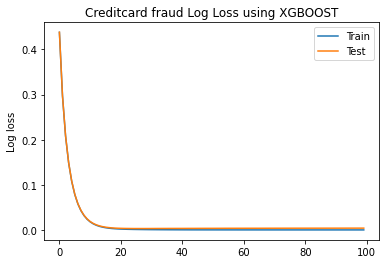

In [18]:
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log loss')
plt.title('Creditcard fraud Log Loss using XGBOOST')
plt.show()

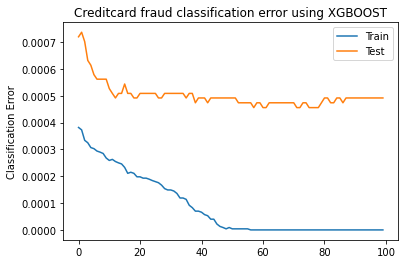

In [19]:
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('Creditcard fraud classification error using XGBOOST')
plt.show()

In [20]:
# early stopping
eval_set = [(X_train, y_train)]
third_model = XGBClassifier()
third_model.fit(
    X_train, 
    y_train, 
    early_stopping_rounds=10,
    eval_metric="logloss",
    eval_set=eval_set,
    verbose=True
    )


D:\anaconda3\envs\ml\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.43781
[1]	validation_0-logloss:0.29712
[2]	validation_0-logloss:0.20797
[3]	validation_0-logloss:0.14865
[4]	validation_0-logloss:0.10757
[5]	validation_0-logloss:0.07849
[6]	validation_0-logloss:0.05777
[7]	validation_0-logloss:0.04271
[8]	validation_0-logloss:0.03179
[9]	validation_0-logloss:0.02377
[10]	validation_0-logloss:0.01788
[11]	validation_0-logloss:0.01353
[12]	validation_0-logloss:0.01034
[13]	validation_0-logloss:0.00799
[14]	validation_0-logloss:0.00624
[15]	validation_0-logloss:0.00494
[16]	validation_0-logloss:0.00395
[17]	validation_0-logloss:0.00321
[18]	validation_0-logloss:0.00266
[19]	validation_0-logloss:0.00224
[20]	validation_0-logloss:0.00191
[21]	validation_0-logloss:0.00167
[22]	validation_0-logloss:0.00146
[23]	validation_0-logloss:0.00130
[24]	validation_0-logloss:0.00116
[25]	validation_0-logloss:0.00105
[26]	validation_0-logloss:0.00095
[27]	validation_0-logloss:0.00087
[28]	validation_0-logloss:0.00078
[29]	validation_0-loglos

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [64]:
third_pred = third_model.predict(X_test)

acc_3rd = accuracy_score(y_test, third_pred)
print(f"Accuracy: {acc_3rd * 100:.2f}%")

Accuracy: 99.95%


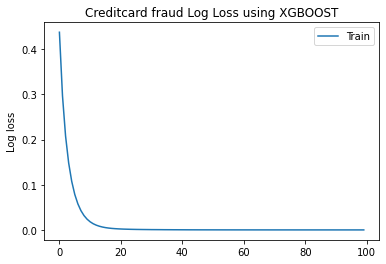

In [65]:
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.legend()
plt.ylabel('Log loss')
plt.title('Creditcard fraud Log Loss using XGBOOST')
plt.show()